In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import logging
import sys

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms


# set logging with INFO level and date format 
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='[%(asctime)s - %(levelname)s] - %(message)s')


# Show Training Dataset

In [3]:
# image datase


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # add noise
    # transforms.RandomErasing(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomErasing()
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = ImageFolder('/home/je689690/CAP5516/chest_xray/train', transform=train_transform)
test_data = ImageFolder('/home/je689690/CAP5516/chest_xray/test', transform=val_transform)
val_data = ImageFolder('/home/je689690/CAP5516/chest_xray/val', transform=val_transform)

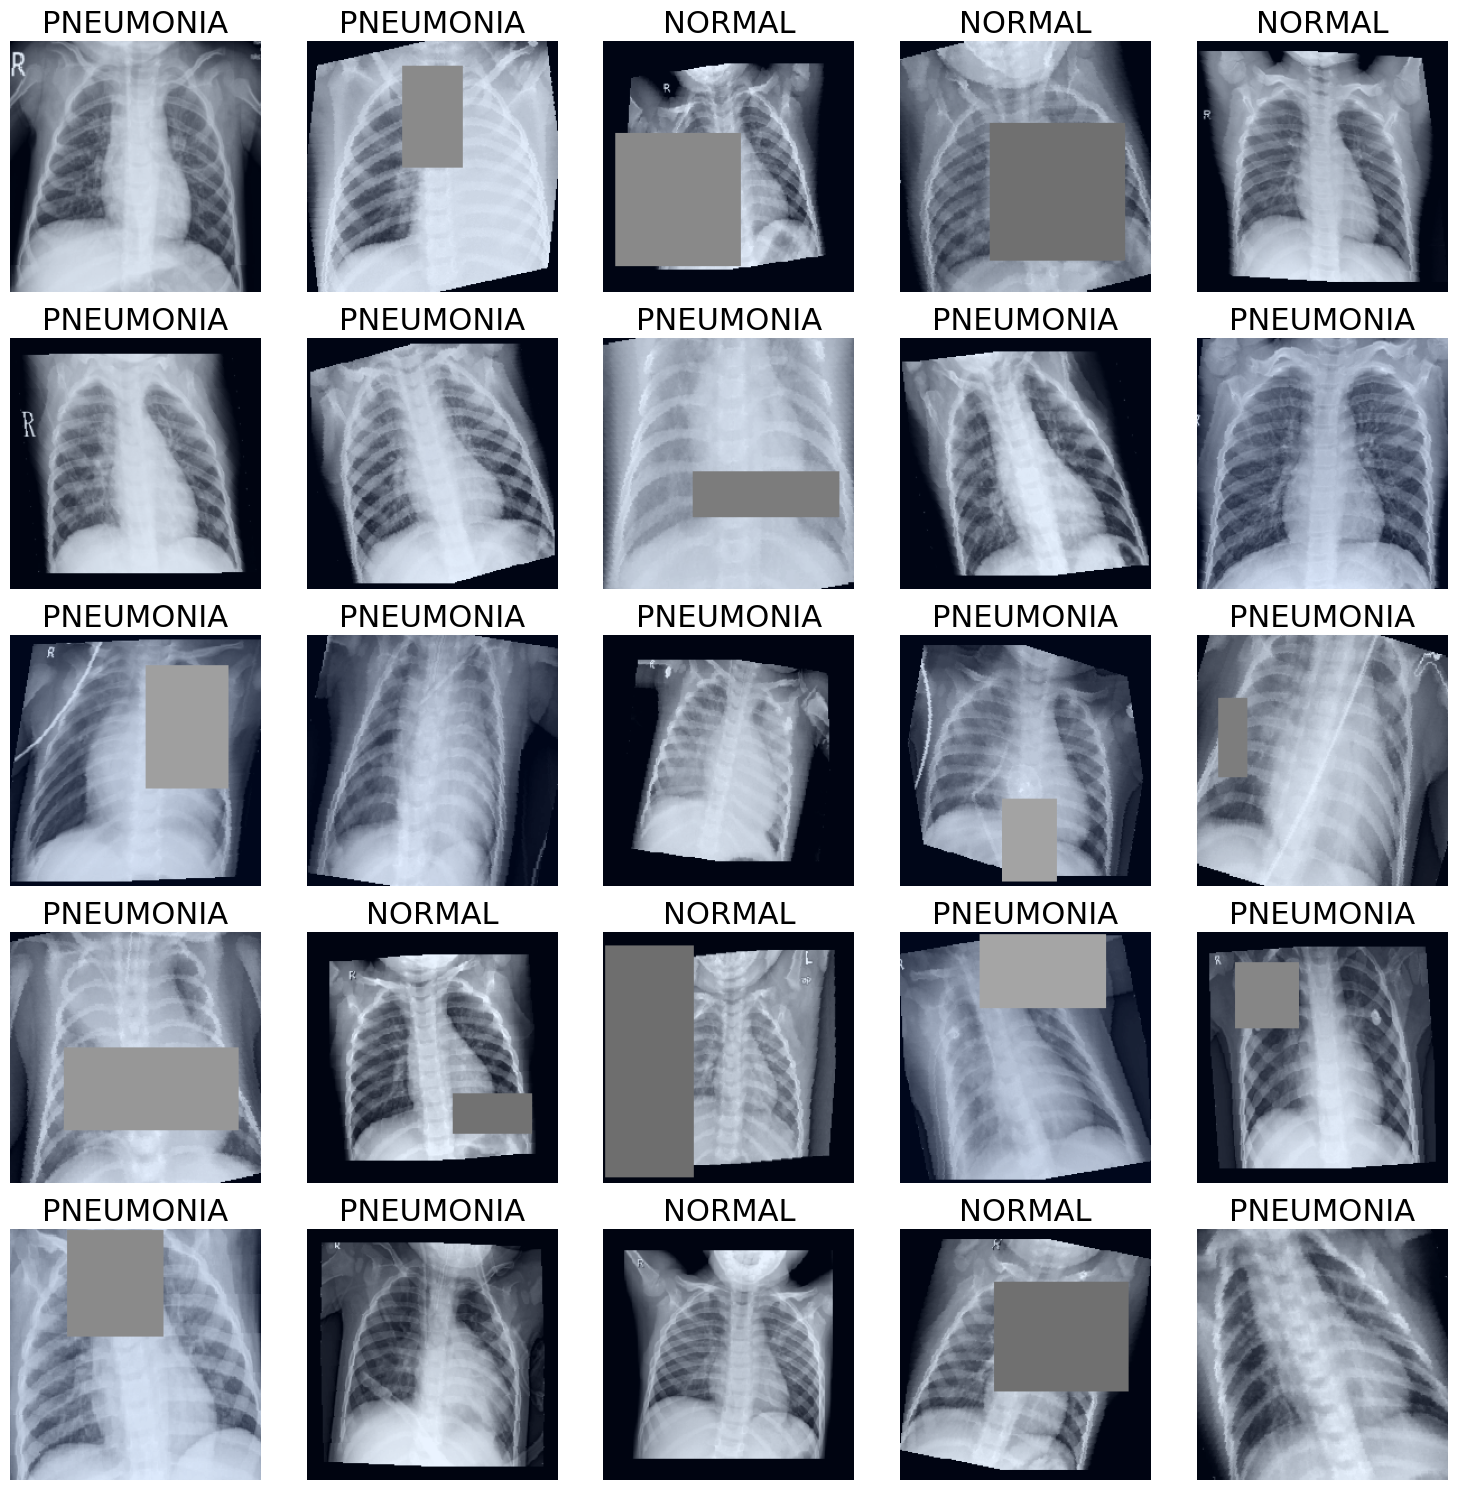

In [4]:
# plot some images

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
ax = ax.flatten()
for i in range(25):
    rand_idx = np.random.randint(0, len(train_data))
    norm_img = train_data[rand_idx][0].permute(1, 2, 0)
    norm_img = (norm_img - norm_img.min()) / (norm_img.max() - norm_img.min())
    ax[i].imshow(norm_img )
    ax[i].set_title(train_data.classes[train_data[rand_idx][1]], fontsize=22)
    ax[i].axis('off')

plt.tight_layout()
plt.savefig('images.png')

## Show Training and Validation Loss

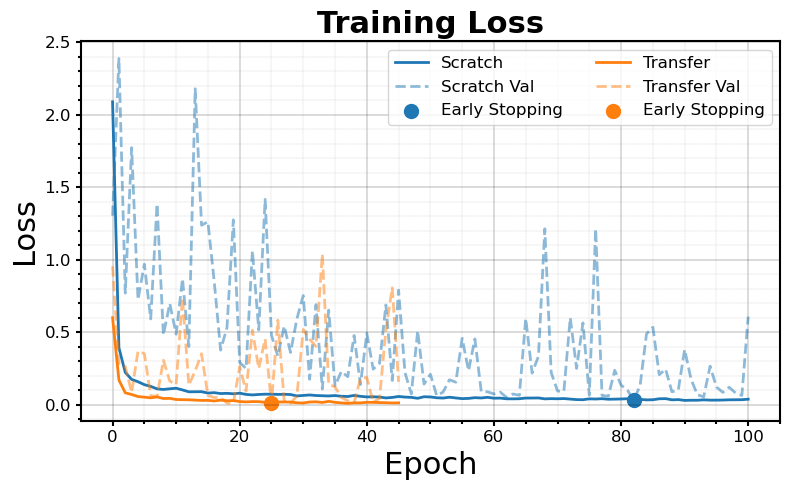

In [5]:
scratch_data = pd.read_csv('/home/je689690/CAP5516/exps/250210_172245-resnet18-scratch/history.csv')
transfer_data = pd.read_csv('/home/je689690/CAP5516/exps/250210_162654-resnet18-imagenet1k/history.csv')
plt.figure(figsize=(8, 5))
ax = plt.gca()


plt.plot(scratch_data['train_loss'].values, label='Scratch', linewidth=2, color='tab:blue')
plt.plot(scratch_data['val_loss'].values, label='Scratch Val', linewidth=2, linestyle='--', color='tab:blue', alpha=0.5)
# early stopping
plt.scatter(scratch_data['val_loss'].idxmin(), scratch_data['val_loss'].min(), label='Early Stopping', color='tab:blue', marker='o', s=100)

plt.plot(transfer_data['train_loss'].values, label='Transfer', linewidth=2, color='tab:orange')
plt.plot(transfer_data['val_loss'].values, label='Transfer Val', linewidth=2, linestyle='--', color='tab:orange', alpha=0.5)
# early stopping
plt.scatter(transfer_data['val_loss'].idxmin(), transfer_data['val_loss'].min(), label='Early Stopping', color='tab:orange', marker='o', s=100)

plt.title('Training Loss', fontsize=22, fontweight='bold')
plt.grid(which='major', linestyle='-',color='black', linewidth=0.2)
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth=0.2)
plt.legend(fontsize=12, ncol=2)

plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Loss', fontsize=22)

# set fontsize for all text in the plot
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# bold ticks and border
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5)
plt.tick_params(axis='both', which='major', labelsize=12, width=1.5)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.tight_layout()
plt.savefig('train_loss.png')



# Evaluate Models

In [6]:
from model import get_model

scratch_weights = '/home/je689690/CAP5516/exps/250210_172245-resnet18-scratch/last.pth'
transfer_weights = '/home/je689690/CAP5516/exps/250210_162654-resnet18-imagenet1k/last.pth'

scratch_model = get_model(classes=2)
scratch_model.load_state_dict(torch.load(scratch_weights))
scratch_model.eval()
scratch_model.cuda()

transfer_model = get_model(classes=2)
transfer_model.load_state_dict(torch.load(transfer_weights))
transfer_model.eval()
transfer_model.cuda();

In [7]:
def eval_model(model, test_data):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    ground_truth = []
    with torch.no_grad():
        for image, label in test_data:
            image = image.unsqueeze(0).cuda()
            pred = model(image)
            pred = torch.argmax(pred, dim=1)
            predictions.append(pred.item())
            ground_truth.append(label)
            correct += (pred == label).item()
            total += 1
    return correct / total, predictions, ground_truth

Scratch Model Accuracy: 0.9086538461538461
Positive Accuracy: 0.9948717948717949
Negative Accuracy: 0.7649572649572649
Sensitivity: 0.9948717948717949
Specificity: 0.7649572649572649
False Positives: 55
False Negatives: 2


NameError: name 'SmoothGradCAMpp' is not defined

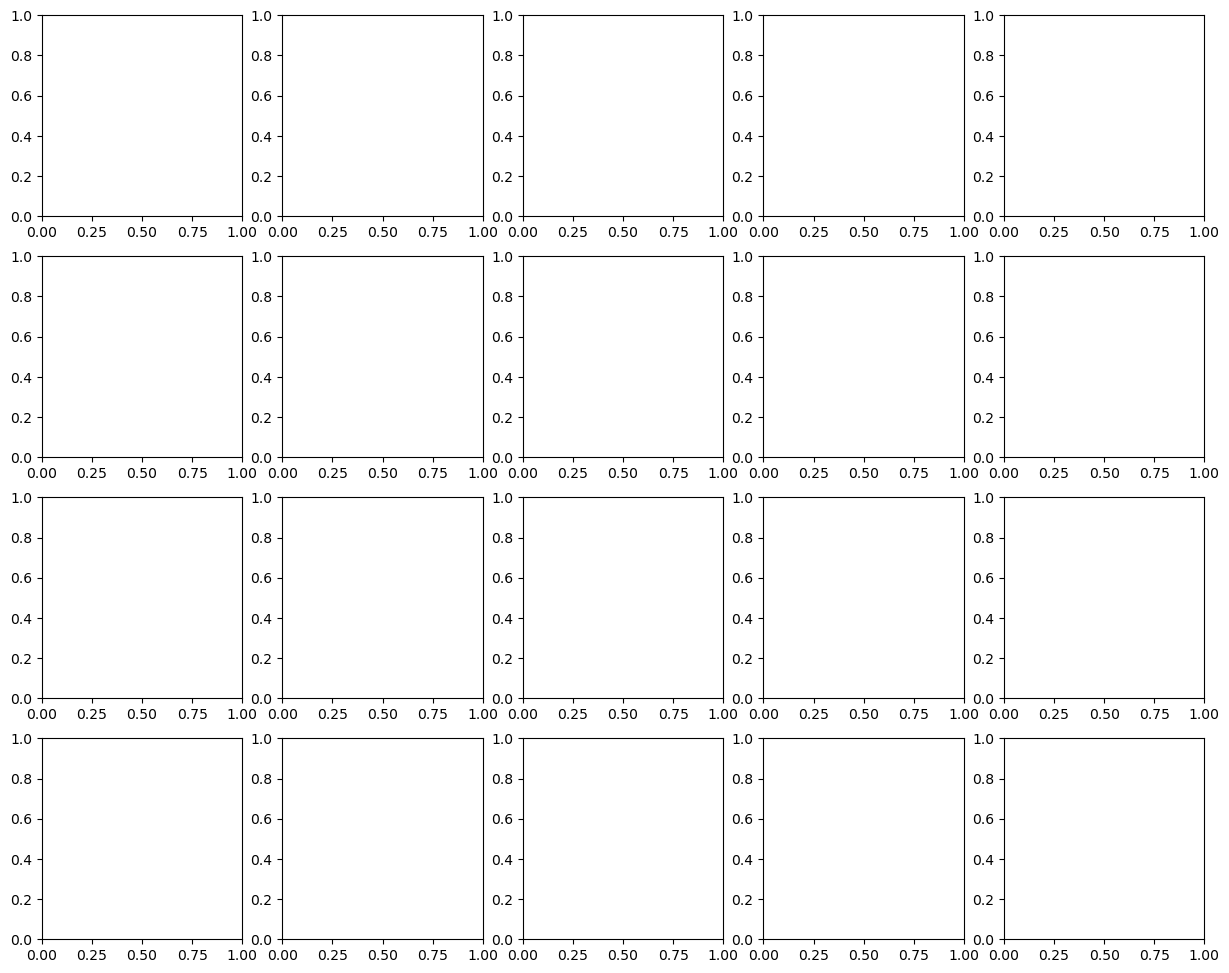

In [8]:
acc, pred, gt = eval_model(scratch_model, test_data)

print(f'Scratch Model Accuracy: {acc}')

predictions = np.array(pred)
ground_truth = np.array(gt)

positve_accuarcy = np.sum((predictions == ground_truth) & (ground_truth == 1)) / np.sum(ground_truth == 1)
negative_accuarcy = np.sum((predictions == ground_truth) & (ground_truth == 0)) / np.sum(ground_truth == 0)
print(f'Positive Accuracy: {positve_accuarcy}')
print(f'Negative Accuracy: {negative_accuarcy}')

true_positives = np.argwhere((ground_truth == 1) & (predictions == 1)).flatten()
true_negatives = np.argwhere((ground_truth == 0) & (predictions == 0)).flatten()
false_positives = np.argwhere((ground_truth == 0) & (predictions == 1)).flatten()
false_negatives = np.argwhere((ground_truth == 1) & (predictions == 0)).flatten()

sensitivity = len(true_positives) / (len(true_positives) + len(false_negatives))
specificity = len(true_negatives) / (len(true_negatives) + len(false_positives))

print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(f'False Positives: {len(false_positives)}')
print(f'False Negatives: {len(false_negatives)}')

# plot some false positives and false negatives

fig, ax = plt.subplots(4, 5, figsize=(15, 12))

ax = ax.flatten()

# from utils import SmoothGradCAMpp, overlay_mask

# plot some true positives
for i in range(5):
    if i >= len(true_positives):
        break
    example = test_data[true_positives[i]][0]
    norm_example = (example - example.min()) / (example.max() - example.min())
    with SmoothGradCAMpp(scratch_model, target_layer='backbone.layer4') as cam_extractor:
        # print(example.shape)
        output = scratch_model(example.unsqueeze(0).cuda())

        activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
    result = overlay_mask(to_pil_image(norm_example), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)

    ax[i].imshow(result)
    ax[i].set_title('True Positive', fontsize=22)
    ax[i].axis('off')

# plot some true negatives

for i in range(5):
    if i >= len(true_negatives):
        break
    example = test_data[true_negatives[i]][0]
    norm_example = (example - example.min()) / (example.max() - example.min())
    with SmoothGradCAMpp(scratch_model, target_layer='backbone.layer4') as cam_extractor:
        # print(example.shape)
        output = scratch_model(example.unsqueeze(0).cuda())

        activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
    result = overlay_mask(to_pil_image(norm_example), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)

    ax[i+5].imshow(result)
    ax[i+5].set_title('True Negative', fontsize=22)
    ax[i+5].axis('off')


for i in range(5):
    if i >= len(false_positives):
        break
    example = test_data[false_positives[i]][0]
    norm_example = (example - example.min()) / (example.max() - example.min())
    with SmoothGradCAMpp(scratch_model, target_layer='backbone.layer4') as cam_extractor:
        output = scratch_model(example.unsqueeze(0).cuda())
        activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
    result = overlay_mask(to_pil_image(norm_example), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)
    ax[i+10].imshow(result)
    ax[i+10].set_title('False Positive', fontsize=22)
    ax[i+10].axis('off')
    if i >= len(false_positives):
        break

for i in range(5):
    if i >= len(false_negatives):
        ax[i+15].axis('off')
        continue
        

    example = test_data[false_negatives[i]][0]
    norm_example = (example - example.min()) / (example.max() - example.min())
    with SmoothGradCAMpp(scratch_model, target_layer='backbone.layer4') as cam_extractor:
        output = scratch_model(example.unsqueeze(0).cuda())
        activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)

    result = overlay_mask(to_pil_image(norm_example), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)
    ax[i+15].imshow(result)
    ax[i+15].set_title('False Negative', fontsize=22)
    ax[i+15].axis('off')

plt.tight_layout()
plt.savefig('false_positives_negatives_scratch_model.png')

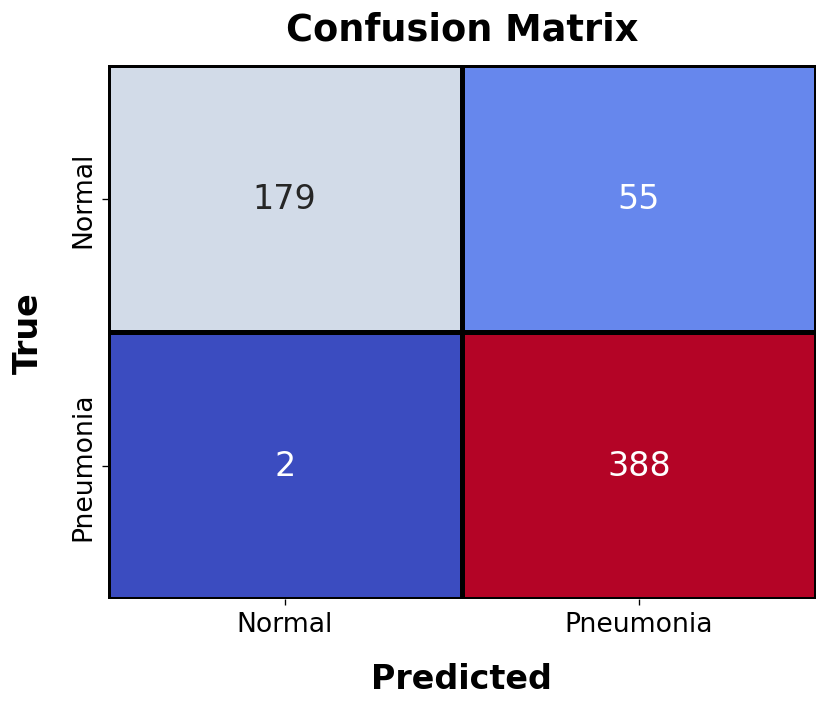

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example ground truth and predictions
# ground_truth = [0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
# predictions = [0, 1, 1, 1, 0, 0, 1, 0, 0, 1]

# Compute confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)

# Define class labels
labels = ['Normal', 'Pneumonia']

# Create figure
plt.figure(figsize=(7, 6), dpi=120)

# Use a diverging colormap and thicker lines
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="coolwarm", cbar=False, 
            linewidths=2, linecolor='black', annot_kws={"size": 20})

# Formatting
plt.xlabel('Predicted', fontsize=20, fontweight='bold', labelpad=15)
plt.ylabel('True', fontsize=20, fontweight='bold', labelpad=15)
plt.title('Confusion Matrix', fontsize=22, fontweight='bold', pad=15)

# Set class labels
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, fontsize=16)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, fontsize=16)

# Adjust layout
plt.tight_layout()
# plt.show()

plt.savefig('confusion_matrix_scratch_model.png')


# Evaluate Tranfer Model

Scratch Model Accuracy: 0.9246794871794872
Positive Accuracy: 0.9666666666666667
Negative Accuracy: 0.8547008547008547
Sensitivity: 0.9666666666666667
Specificity: 0.8547008547008547
False Positives: 34
False Negatives: 13


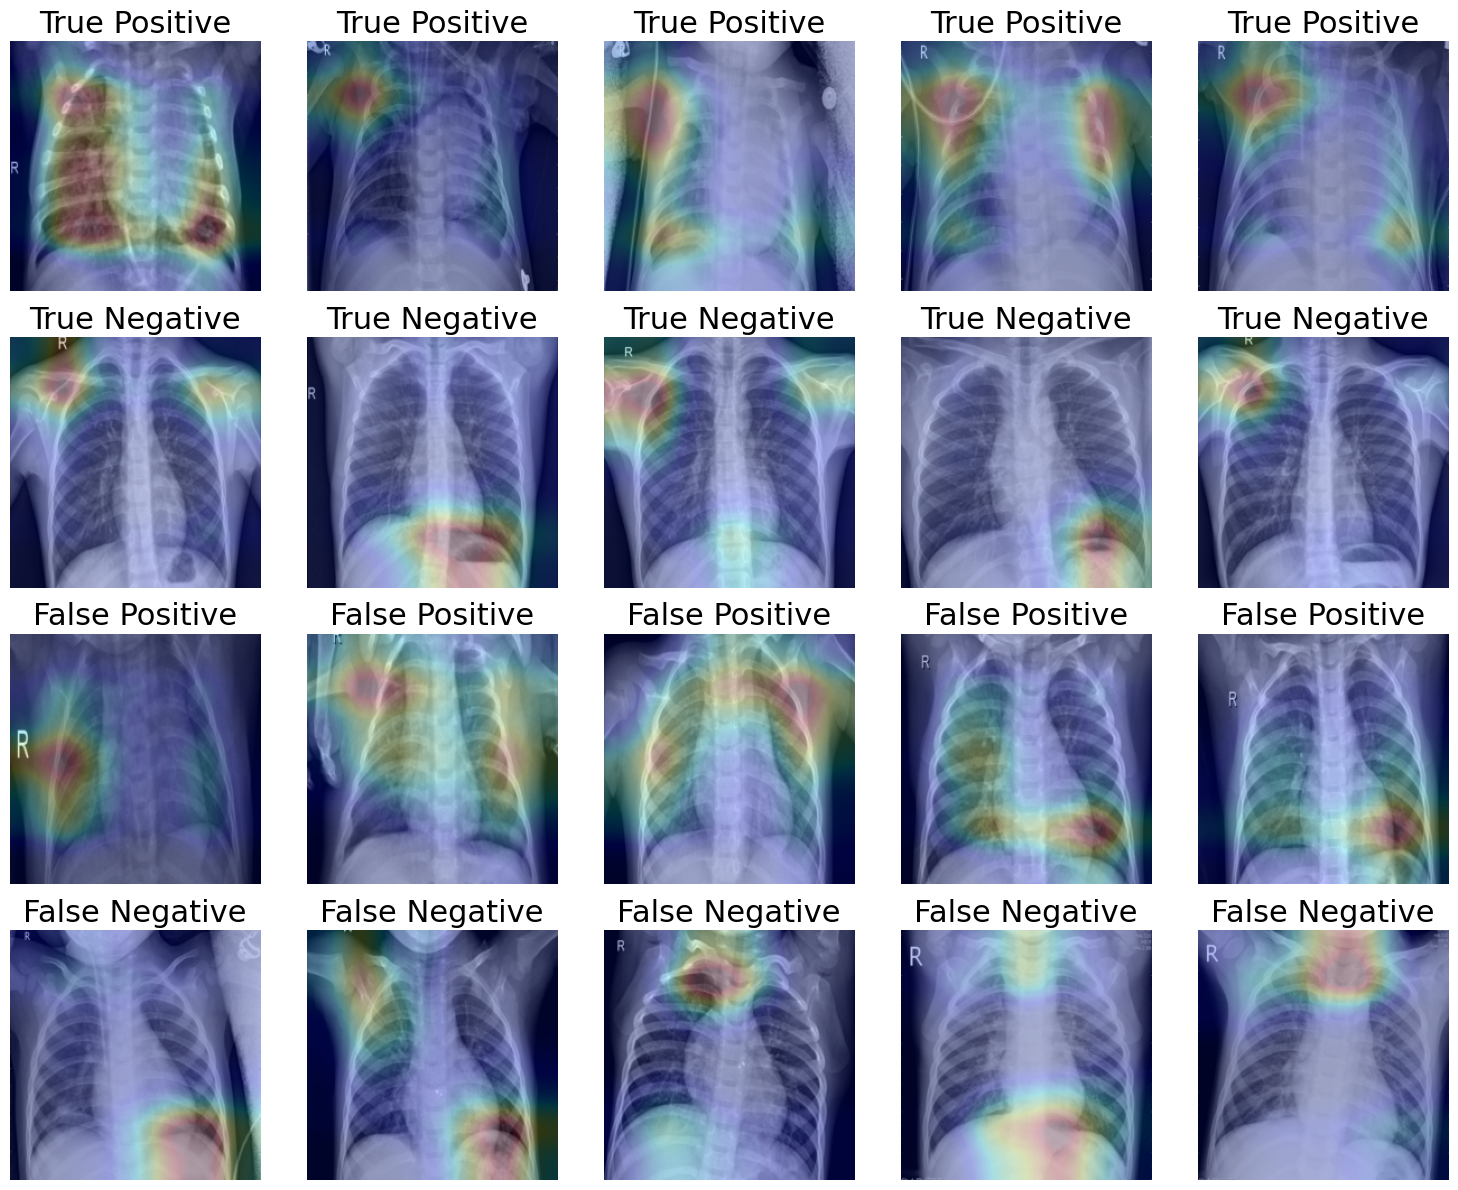

In [9]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


acc, pred, gt = eval_model(transfer_model, test_data)
# tranfer_cam_extractor = SmoothGradCAMpp(transfer_model)

print(f'Scratch Model Accuracy: {acc}')

predictions = np.array(pred)
ground_truth = np.array(gt)

positve_accuarcy = np.sum((predictions == ground_truth) & (ground_truth == 1)) / np.sum(ground_truth == 1)
negative_accuarcy = np.sum((predictions == ground_truth) & (ground_truth == 0)) / np.sum(ground_truth == 0)
print(f'Positive Accuracy: {positve_accuarcy}')
print(f'Negative Accuracy: {negative_accuarcy}')
true_positives = np.argwhere((ground_truth == 1) & (predictions == 1)).flatten()
true_negatives = np.argwhere((ground_truth == 0) & (predictions == 0)).flatten()
false_positives = np.argwhere((ground_truth == 0) & (predictions == 1)).flatten()
false_negatives = np.argwhere((ground_truth == 1) & (predictions == 0)).flatten()

sensitivity = len(true_positives) / (len(true_positives) + len(false_negatives))
specificity = len(true_negatives) / (len(true_negatives) + len(false_positives))

print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(f'False Positives: {len(false_positives)}')
print(f'False Negatives: {len(false_negatives)}')

# plot some false positives and false negatives

fig, ax = plt.subplots(4, 5, figsize=(15, 12))

ax = ax.flatten()

# plot some true positives
for i in range(5):
    if i >= len(true_positives):
        break
    example = test_data[true_positives[i]][0]
    norm_example = (example - example.min()) / (example.max() - example.min())
    with SmoothGradCAMpp(transfer_model, target_layer='backbone.layer4') as cam_extractor:
        # print(example.shape)
        output = transfer_model(example.unsqueeze(0).cuda())

        activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
    result = overlay_mask(to_pil_image(norm_example), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)

    ax[i].imshow(result)
    ax[i].set_title('True Positive', fontsize=22)
    ax[i].axis('off')

# plot some true negatives

for i in range(5):
    if i >= len(true_negatives):
        break
    example = test_data[true_negatives[i]][0]
    norm_example = (example - example.min()) / (example.max() - example.min())
    with SmoothGradCAMpp(transfer_model, target_layer='backbone.layer4') as cam_extractor:
        # print(example.shape)
        output = transfer_model(example.unsqueeze(0).cuda())

        activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
    result = overlay_mask(to_pil_image(norm_example), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)

    ax[i+5].imshow(result)
    ax[i+5].set_title('True Negative', fontsize=22)
    ax[i+5].axis('off')


# plot some false positives
for i in range(5):
    if i >= len(false_positives):
        break
    example = test_data[false_positives[i]][0]
    norm_example = (example - example.min()) / (example.max() - example.min())
    with SmoothGradCAMpp(transfer_model, target_layer='backbone.layer4') as cam_extractor:
        # print(example.shape)
        output = transfer_model(example.unsqueeze(0).cuda())

        activation_map = cam_extractor(output.squeeze(0).argmax().item(), output )
    result = overlay_mask(to_pil_image(norm_example), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)

    ax[i + 10].imshow(result)
    ax[i + 10].set_title('False Positive', fontsize=22)
    ax[i + 10].axis('off')

# plot some false negatives
for i in range(5):
    if i >= len(false_negatives):
        break

    example = test_data[false_negatives[i]][0]
    norm_example = (example - example.min()) / (example.max() - example.min())
    with SmoothGradCAMpp(transfer_model, target_layer='backbone.layer4') as cam_extractor:
        # print(example.shape)
        output = transfer_model(example.unsqueeze(0).cuda())

        activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
    result = overlay_mask(to_pil_image(norm_example ), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)

    ax[i+15].imshow(result)
    ax[i+15].set_title('False Negative', fontsize=22)
    ax[i+15].axis('off')

plt.tight_layout()
plt.savefig('false_positives_negatives_transfer_model.png')

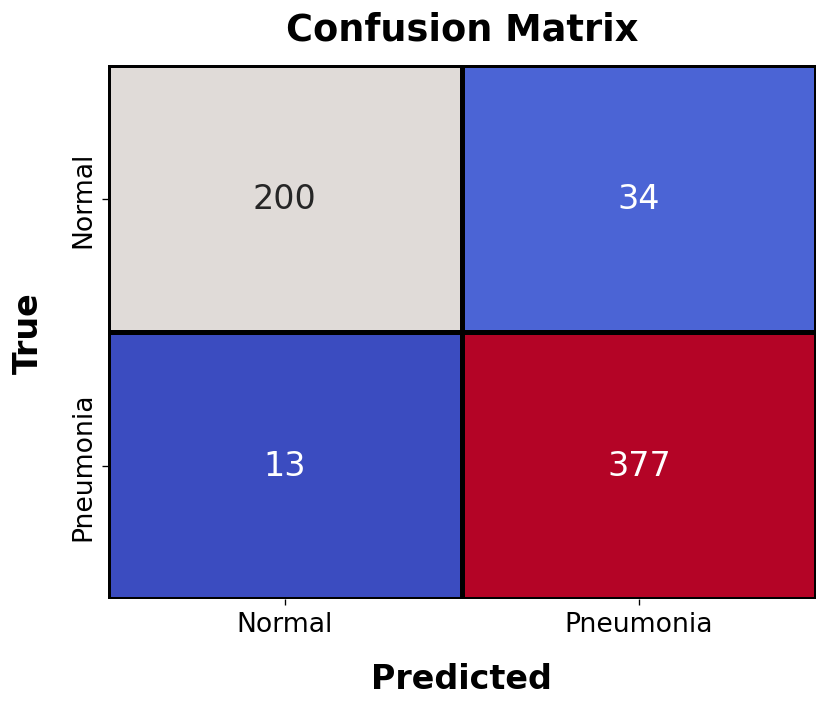

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example ground truth and predictions
# ground_truth = [0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
# predictions = [0, 1, 1, 1, 0, 0, 1, 0, 0, 1]

# Compute confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)

# Define class labels
labels = ['Normal', 'Pneumonia']

# Create figure
plt.figure(figsize=(7, 6), dpi=120)

# Use a diverging colormap and thicker lines
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="coolwarm", cbar=False, 
            linewidths=2, linecolor='black', annot_kws={"size": 20})

# Formatting
plt.xlabel('Predicted', fontsize=20, fontweight='bold', labelpad=15)
plt.ylabel('True', fontsize=20, fontweight='bold', labelpad=15)
plt.title('Confusion Matrix', fontsize=22, fontweight='bold', pad=15)

# Set class labels
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, fontsize=16)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, fontsize=16)

# Adjust layout
plt.tight_layout()
# plt.show()

plt.savefig('confusion_matrix_transfer_model.png')
